<a href="https://colab.research.google.com/github/donw385/DS-Sprint-01-Dealing-With-Data/blob/master/module4-databackedassertions/LS_DS_114_Making_Data_backed_Assertions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lambda School Data Science - Making Data-backed Assertions

This is, for many, the main point of data science - to create and support reasoned arguments based on evidence. It's not a topic to master in a day, but it is worth some focused time thinking about and structuring your approach to it.

## Lecture - generating a confounding variable

The prewatch material told a story about a hypothetical health condition where both the drug usage and overall health outcome were related to gender - thus making gender a confounding variable, obfuscating the possible relationship between the drug and the outcome.

Let's use Python to generate data that actually behaves in this fashion!

In [51]:
import matplotlib
import matplotlib.pyplot as plt


import numpy

import random
dir(random)  # Reminding ourselves what we can do here

['BPF',
 'LOG4',
 'NV_MAGICCONST',
 'RECIP_BPF',
 'Random',
 'SG_MAGICCONST',
 'SystemRandom',
 'TWOPI',
 '_BuiltinMethodType',
 '_MethodType',
 '_Sequence',
 '_Set',
 '__all__',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__spec__',
 '_acos',
 '_bisect',
 '_ceil',
 '_cos',
 '_e',
 '_exp',
 '_inst',
 '_itertools',
 '_log',
 '_pi',
 '_random',
 '_sha512',
 '_sin',
 '_sqrt',
 '_test',
 '_test_generator',
 '_urandom',
 '_warn',
 'betavariate',
 'choice',
 'choices',
 'expovariate',
 'gammavariate',
 'gauss',
 'getrandbits',
 'getstate',
 'lognormvariate',
 'normalvariate',
 'paretovariate',
 'randint',
 'random',
 'randrange',
 'sample',
 'seed',
 'setstate',
 'shuffle',
 'triangular',
 'uniform',
 'vonmisesvariate',
 'weibullvariate']

In [0]:
# Let's think of another scenario:
# We work for a company that sells accessories for mobile phones.
# They have an ecommerce site, and we are supposed to analyze logs
# to determine what sort of usage is related to purchases, and thus guide
# website development to encourage higher conversion.

# The hypothesis - users who spend longer on the site tend
# to spend more. Seems reasonable, no?

# But there's a confounding variable! If they're on a phone, they:
# a) Spend less time on the site, but
# b) Are more likely to be interested in the actual products!

# Let's use namedtuple to represent our data

from collections import namedtuple
# purchased and mobile are bools, time_on_site in seconds
User = namedtuple('User', ['purchased','time_on_site', 'mobile'])

example_user = User(False, 12, False)
print(example_user)

User(purchased=False, time_on_site=12, mobile=False)


In [0]:
# And now let's generate 1000 example users
# 750 mobile, 250 not (i.e. desktop)
# A desktop user has a base conversion likelihood of 10%
# And it goes up by 1% for each 15 seconds they spend on the site
# And they spend anywhere from 10 seconds to 10 minutes on the site (uniform)
# Mobile users spend on average half as much time on the site as desktop
# But have twice as much base likelihood of buying something

users = []

for _ in range(250):
  # Desktop users
  time_on_site = random.uniform(10, 600)
  purchased = random.random() < 0.1 + (time_on_site // 1500)
  users.append(User(purchased, time_on_site, False))
  
for _ in range(750):
  # Mobile users
  time_on_site = random.uniform(5, 300)
  purchased = random.random() < 0.2 + (time_on_site // 1500)
  users.append(User(purchased, time_on_site, True))
  
random.shuffle(users)
print(users[:10])

[User(purchased=True, time_on_site=51.27167908202069, mobile=True), User(purchased=True, time_on_site=218.39905655655537, mobile=True), User(purchased=False, time_on_site=293.8837856281192, mobile=True), User(purchased=False, time_on_site=210.6664621881297, mobile=True), User(purchased=False, time_on_site=73.30358974813367, mobile=False), User(purchased=False, time_on_site=191.36109094508433, mobile=True), User(purchased=False, time_on_site=202.86335335101984, mobile=True), User(purchased=False, time_on_site=25.46984971755341, mobile=True), User(purchased=False, time_on_site=157.24103230710188, mobile=True), User(purchased=False, time_on_site=395.6857842063654, mobile=False)]


In [0]:
# Let's put this in a dataframe so we can look at it more easily
import pandas as pd
user_data = pd.DataFrame(users)
user_data.head()

,purchased,time_on_site,mobile
0,True,51.271679,True
1,True,218.399057,True
2,False,293.883786,True
3,False,210.666462,True
4,False,73.303590,False


In [0]:
# Let's use crosstabulation to try to see what's going on
pd.crosstab(user_data['purchased'], user_data['time_on_site'])

time_on_site,5.23970985040799,5.705512750941858,6.316870902692591,6.6080795023116465,7.160169977941848,7.96000458456959,9.534041392409522,9.829020078035184,10.023366924817001,10.13096640376069,...,568.3228834818145,569.3061651165532,570.2977104816991,570.8402803413865,577.4514517200215,578.0620436880133,583.3963861896933,585.6557655610828,591.8423073884194,597.1060871155424
purchased,,,,,,,,,,,,,,,,,,,,,
False,1,0,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
True,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [0]:
# OK, that's not quite what we want
# Time is continuous! We need to put it in discrete buckets
# Pandas calls these bins, and pandas.cut helps make them

time_bins = pd.cut(user_data['time_on_site'], 5)  # 5 equal-sized bins
pd.crosstab(user_data['purchased'], time_bins)

time_on_site,"(4.648, 123.613]","(123.613, 241.986]","(241.986, 360.36]","(360.36, 478.733]","(478.733, 597.106]"
purchased,,,,,
False,269,278,162,47,45
True,70,79,39,7,4


In [0]:
# We can make this a bit clearer by normalizing (getting %)
pd.crosstab(user_data['purchased'], time_bins, normalize='columns')

time_on_site,"(4.648, 123.613]","(123.613, 241.986]","(241.986, 360.36]","(360.36, 478.733]","(478.733, 597.106]"
purchased,,,,,
False,0.79351,0.778711,0.80597,0.87037,0.918367
True,0.20649,0.221289,0.19403,0.12963,0.081633


In [0]:
# That seems counter to our hypothesis
# More time on the site seems to have fewer purchases

# But we know why, since we generated the data!
# Let's look at mobile and purchased
pd.crosstab(user_data['purchased'], user_data['mobile'], normalize='columns')

mobile,False,True
purchased,,
False,0.876,0.776
True,0.124,0.224


In [0]:
# Yep, mobile users are more likely to buy things
# But we're still not seeing the *whole* story until we look at all 3 at once

# Live/stretch goal - how can we do that?

a= time_bins
b = user_data['purchased']
c = user_data['mobile']


pd.crosstab(a, [b, c], rownames=['time_bins'], colnames=['purchased', 'mobile'], normalize='index')

purchased              False               True           
mobile                 False     True      False     True 
time_bins                                                 
(4.648, 123.613]    0.117994  0.675516  0.026549  0.179941
(123.613, 241.986]  0.128852  0.649860  0.008403  0.212885
(241.986, 360.36]   0.203980  0.601990  0.039801  0.154229
(360.36, 478.733]   0.870370  0.000000  0.129630  0.000000
(478.733, 597.106]  0.918367  0.000000  0.081633  0.000000

In [0]:
user_data.corr()

,purchased,time_on_site,mobile
purchased,1.000000,-0.054904,0.108457
time_on_site,-0.054904,1.000000,-0.500495
mobile,0.108457,-0.500495,1.000000


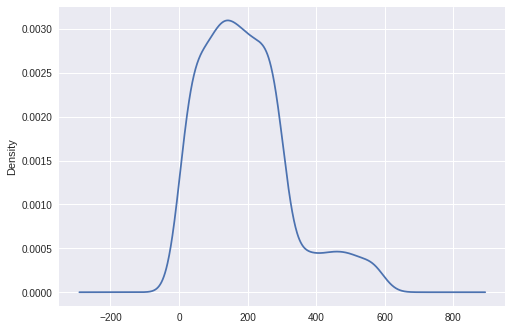

In [0]:
user_data['time_on_site'].plot.density()
plot.show()

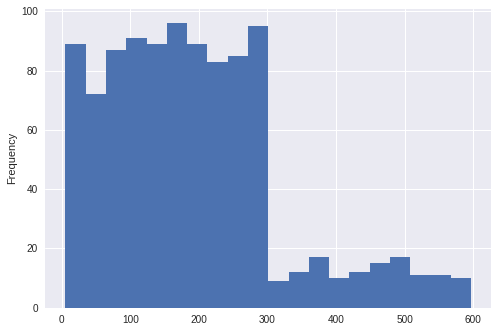

In [0]:
user_data['time_on_site'].plot.hist(bins=20)
plot.show()

## Assignment - what's going on here?

Consider the data in `persons.csv` (already prepared for you, in the repo for the week). It has four columns - a unique id, followed by age (in years), weight (in lbs), and exercise time (in minutes/week) of 1200 (hypothetical) people.

Try to figure out which variables are possibly related to each other, and which may be confounding relationships.

In [45]:
# TODO - your code here
# Use what we did live in lecture as an example

# HINT - you can find the raw URL on GitHub and potentially use that
# to load the data with read_csv, or you can upload it yourself

persons = pd.read_csv('https://raw.githubusercontent.com/donw385/DS-Sprint-01-Dealing-With-Data/master/module4-databackedassertions/persons.csv')
persons.head()



,Unnamed: 0,age,weight,exercise_time
0,0,44,118,192
1,1,41,161,35
2,2,46,128,220
3,3,39,216,57
4,4,28,116,182


In [60]:
time_bins = pd.cut(persons['exercise_time'], 5)  # 5 equal-sized bins
age_bins = pd.cut(persons['age'], 5)
weight_bins = pd.cut(persons['weight'], 5)

a= time_bins
b = age_bins
c = weight_bins


pd.crosstab(a, [b, c], rownames=['time_bins'], colnames=['age_bins', 'weight_bins'], normalize='index')

age_bins        (17.938, 30.4]                                               \
weight_bins    (99.854, 129.2] (129.2, 158.4] (158.4, 187.6] (187.6, 216.8]   
time_bins                                                                     
(-0.3, 60.0]          0.035971       0.025180       0.039568       0.061151   
(60.0, 120.0]         0.028481       0.047468       0.037975       0.031646   
(120.0, 180.0]        0.076233       0.089686       0.044843       0.031390   
(180.0, 240.0]        0.098958       0.151042       0.067708       0.000000   
(240.0, 300.0]        0.130890       0.078534       0.015707       0.000000   

age_bins                         (30.4, 42.8]                                \
weight_bins    (216.8, 246.0] (99.854, 129.2] (129.2, 158.4] (158.4, 187.6]   
time_bins                                                                     
(-0.3, 60.0]          0.02518        0.028777       0.035971       0.035971   
(60.0, 120.0]         0.00000        0.060127       0.025316       0.050633   
(120.0, 180.0]        0.00000        0.085202       0.035874       0.058296   
(180.0, 240.0]        0.00000        0.130208       0.078125       0.036458   
(240.0, 300.0]        0.00000        0.172775       0.109948       0.015707   

age_bins                                          ...          (55.2, 67.6]  \
weight_bins    (187.6, 216.8] (216.8, 246.0]      ...       (99.854, 129.2]   
time_bins                                         ...                         
(-0.3, 60.0]         0.061151        0.02518      ...              0.025180   
(60.0, 120.0]        0.037975        0.00000      ...              0.031646   
(120.0, 180.0]       0.008969        0.00000      ...              0.058296   
(180.0, 240.0]       0.000000        0.00000      ...              0.062500   
(240.0, 300.0]       0.000000        0.00000      ...              0.057592   

age_bins                                                                    \
weight_bins    (129.2, 158.4] (158.4, 187.6] (187.6, 216.8] (216.8, 246.0]   
time_bins                                                                    
(-0.3, 60.0]         0.021583       0.035971       0.053957       0.028777   
(60.0, 120.0]        0.063291       0.060127       0.066456       0.003165   
(120.0, 180.0]       0.062780       0.026906       0.031390       0.000000   
(180.0, 240.0]       0.098958       0.046875       0.005208       0.000000   
(240.0, 300.0]       0.062827       0.005236       0.000000       0.000000   

age_bins          (67.6, 80.0]                                               \
weight_bins    (99.854, 129.2] (129.2, 158.4] (158.4, 187.6] (187.6, 216.8]   
time_bins                                                                     
(-0.3, 60.0]          0.075540       0.050360       0.068345       0.064748   
(60.0, 120.0]         0.066456       0.075949       0.101266       0.056962   
(120.0, 180.0]        0.058296       0.053812       0.067265       0.035874   
(180.0, 240.0]        0.026042       0.020833       0.000000       0.000000   
(240.0, 300.0]        0.000000       0.000000       0.000000       0.000000   

age_bins                       
weight_bins    (216.8, 246.0]  
time_bins                      
(-0.3, 60.0]         0.053957  
(60.0, 120.0]        0.022152  
(120.0, 180.0]       0.000000  
(180.0, 240.0]       0.000000  
(240.0, 300.0]       0.000000  

[5 rows x 25 columns]

In [61]:
time_bins = pd.cut(persons['exercise_time'], 5)  # 5 equal-sized bins
age_bins = pd.cut(persons['age'], 5)
weight_bins = pd.cut(persons['weight'], 5)

a= time_bins
b = age_bins
c = weight_bins


pd.crosstab(a, [c, b], rownames=['time_bins'], colnames=['weight_bins','age_bins'], normalize='index')

weight_bins    (99.854, 129.2]                                         \
age_bins        (17.938, 30.4] (30.4, 42.8] (42.8, 55.2] (55.2, 67.6]   
time_bins                                                               
(-0.3, 60.0]          0.035971     0.028777     0.025180     0.025180   
(60.0, 120.0]         0.028481     0.060127     0.018987     0.031646   
(120.0, 180.0]        0.076233     0.085202     0.040359     0.058296   
(180.0, 240.0]        0.098958     0.130208     0.093750     0.062500   
(240.0, 300.0]        0.130890     0.172775     0.198953     0.057592   

weight_bins                 (129.2, 158.4]                            \
age_bins       (67.6, 80.0] (17.938, 30.4] (30.4, 42.8] (42.8, 55.2]   
time_bins                                                              
(-0.3, 60.0]       0.075540       0.025180     0.035971     0.025180   
(60.0, 120.0]      0.066456       0.047468     0.025316     0.028481   
(120.0, 180.0]     0.058296       0.089686     0.035874     0.058296   
(180.0, 240.0]     0.026042       0.151042     0.078125     0.036458   
(240.0, 300.0]     0.000000       0.078534     0.109948     0.136126   

weight_bins                                  ...      (187.6, 216.8]  \
age_bins       (55.2, 67.6] (67.6, 80.0]     ...      (17.938, 30.4]   
time_bins                                    ...                       
(-0.3, 60.0]       0.021583     0.050360     ...            0.061151   
(60.0, 120.0]      0.063291     0.075949     ...            0.031646   
(120.0, 180.0]     0.062780     0.053812     ...            0.031390   
(180.0, 240.0]     0.098958     0.020833     ...            0.000000   
(240.0, 300.0]     0.062827     0.000000     ...            0.000000   

weight_bins                                                         \
age_bins       (30.4, 42.8] (42.8, 55.2] (55.2, 67.6] (67.6, 80.0]   
time_bins                                                            
(-0.3, 60.0]       0.061151     0.032374     0.053957     0.064748   
(60.0, 120.0]      0.037975     0.037975     0.066456     0.056962   
(120.0, 180.0]     0.008969     0.022422     0.031390     0.035874   
(180.0, 240.0]     0.000000     0.000000     0.005208     0.000000   
(240.0, 300.0]     0.000000     0.000000     0.000000     0.000000   

weight_bins    (216.8, 246.0]                                         \
age_bins       (17.938, 30.4] (30.4, 42.8] (42.8, 55.2] (55.2, 67.6]   
time_bins                                                              
(-0.3, 60.0]          0.02518      0.02518     0.025180     0.028777   
(60.0, 120.0]         0.00000      0.00000     0.003165     0.003165   
(120.0, 180.0]        0.00000      0.00000     0.000000     0.000000   
(180.0, 240.0]        0.00000      0.00000     0.000000     0.000000   
(240.0, 300.0]        0.00000      0.00000     0.000000     0.000000   

weight_bins                  
age_bins       (67.6, 80.0]  
time_bins                    
(-0.3, 60.0]       0.053957  
(60.0, 120.0]      0.022152  
(120.0, 180.0]     0.000000  
(180.0, 240.0]     0.000000  
(240.0, 300.0]     0.000000  

[5 rows x 25 columns]

In [65]:
pd.crosstab(c, b, normalize='index')

age,"(17.938, 30.4]","(30.4, 42.8]","(42.8, 55.2]","(55.2, 67.6]","(67.6, 80.0]"
weight,,,,,
"(99.854, 129.2]",0.213333,0.277333,0.208000,0.141333,0.160000
"(129.2, 158.4]",0.256716,0.185075,0.185075,0.211940,0.161194
"(158.4, 187.6]",0.189922,0.189922,0.189922,0.174419,0.255814
"(187.6, 216.8]",0.189944,0.173184,0.145251,0.245810,0.245810
"(216.8, 246.0]",0.132075,0.132075,0.150943,0.169811,0.415094


In [56]:
persons.corr()

,Unnamed: 0,age,weight,exercise_time
Unnamed: 0,1.000000,-0.000418,-0.060297,-0.020138
age,-0.000418,1.000000,0.144168,-0.273818
weight,-0.060297,0.144168,1.000000,-0.478021
exercise_time,-0.020138,-0.273818,-0.478021,1.000000


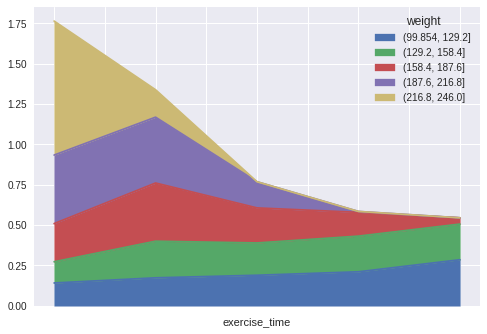

In [49]:
ax=pd.crosstab(time_bins, weight_bins,normalize='columns')
ax.plot.area()

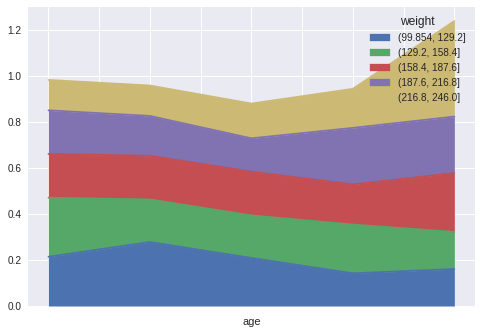

In [64]:
ax=pd.crosstab(age_bins, weight_bins,normalize='columns')
ax.plot.area()

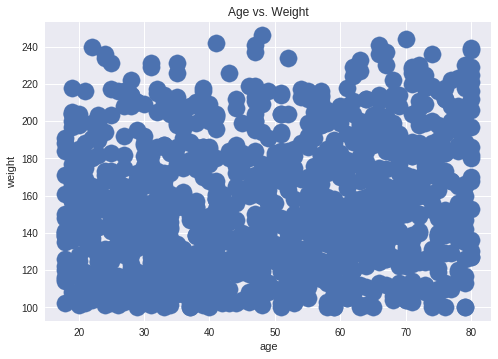

In [53]:
plt.scatter(persons['age'], persons['weight'], s=300)
plt.title('Age vs. Weight')
plt.xlabel('age')
plt.ylabel('weight')
plt.show()

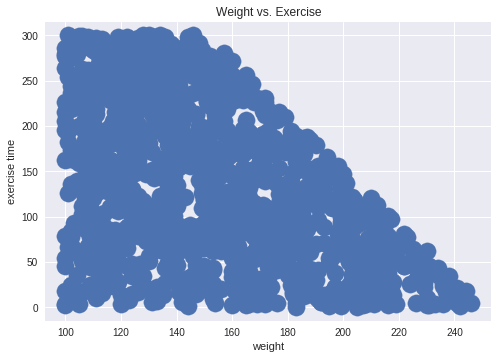

In [54]:
plt.scatter(persons['weight'], persons['exercise_time'], s=300)
plt.title('Weight vs. Exercise')
plt.xlabel('weight')
plt.ylabel('exercise time')
plt.show()

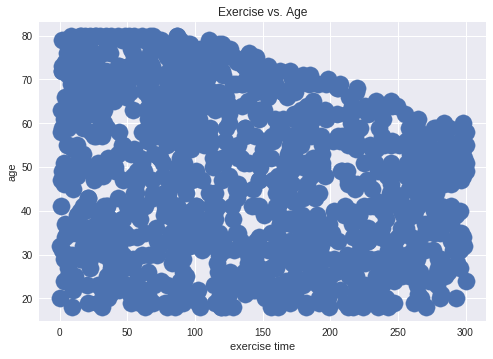

In [55]:
plt.scatter(persons['exercise_time'], persons['age'], s=300)
plt.title('Exercise vs. Age')
plt.xlabel('exercise time')
plt.ylabel('age')
plt.show()

### Assignment questions

After you've worked on some code, answer the following questions in this text block:

1.  What are the variable types in the data?
exercise time is independent, weight is dependent, and age is confounding
2.  What are the relationships between the variables?
weight gain and time and negatively correlated, slightly positive corelation between age and weight, slightly negative correlation between age and exercise time
3.  Which relationships are "real", and which spurious?
age is confounding variable, different ages of people tend to be different weights, so can throw it off if one cohort is older one is younger, but overall it does seem as if more exercise tends to lead to lower weight.



## Stretch goals and resources

Following are *optional* things for you to take a look at. Focus on the above assignment first, and make sure to commit and push your changes to GitHub.

- [Spurious Correlations](http://tylervigen.com/spurious-correlations)
- [NIH on controlling for confounding variables](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4017459/)

Stretch goals:

- Produce your own plot inspierd by the Spurious Correlation visualizations (and consider writing a blog post about it - both the content and how you made it)
- Pick one of the techniques that NIH highlights for confounding variables - we'll be going into many of them later, but see if you can find which Python modules may help (hint - check scikit-learn)